Based on  the excellent [GAN in Pytorch tutorial](https://www.youtube.com/watch?v=OljTVUVzPpM)

In [20]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1 
batch_size = 32
num_epochs = 50


In [6]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  ])

In [7]:
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
step = 0

In [17]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device) # flatten it 
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()



Epoch [0/50] Batch 0/1875                       Loss D: 0.5129, loss G: 1.3323
Epoch [1/50] Batch 0/1875                       Loss D: 0.7250, loss G: 0.6861
Epoch [2/50] Batch 0/1875                       Loss D: 0.5944, loss G: 1.2845
Epoch [3/50] Batch 0/1875                       Loss D: 0.5445, loss G: 1.3436
Epoch [4/50] Batch 0/1875                       Loss D: 0.4289, loss G: 1.5111
Epoch [5/50] Batch 0/1875                       Loss D: 0.3947, loss G: 1.8922
Epoch [6/50] Batch 0/1875                       Loss D: 0.5953, loss G: 1.1589
Epoch [7/50] Batch 0/1875                       Loss D: 0.4977, loss G: 1.2029
Epoch [8/50] Batch 0/1875                       Loss D: 0.6377, loss G: 1.2340
Epoch [9/50] Batch 0/1875                       Loss D: 0.8241, loss G: 1.0343
Epoch [10/50] Batch 0/1875                       Loss D: 0.8360, loss G: 0.8956
Epoch [11/50] Batch 0/1875                       Loss D: 0.6498, loss G: 1.2152
Epoch [12/50] Batch 0/1875                       L

In [18]:
for batch_idx, (real, _) in enumerate(loader):
    with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
        data = real.reshape(-1, 1, 28, 28)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        img_grid_real = torchvision.utils.make_grid(data, normalize=True)
    break 

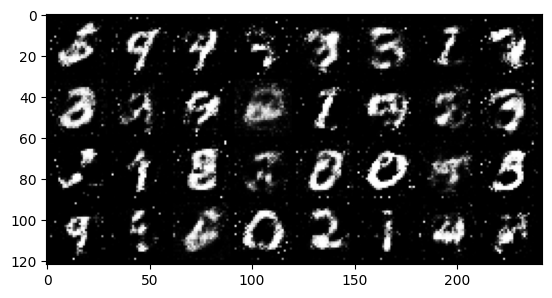

In [19]:
import matplotlib.pyplot as plt 
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())

# Trying the original variant of the loss

In [21]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  ])

In [22]:
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
step = 0

In [24]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device) # flatten it 
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z)))
        output = disc(fake).view(-1)
        lossG = -1 * criterion(output, torch.zeros_like(output)) # Minimize this 
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )



Epoch [0/50] Batch 0/1875                       Loss D: 0.2438, loss G: -0.2332
Epoch [1/50] Batch 0/1875                       Loss D: 0.7909, loss G: -0.8563
Epoch [2/50] Batch 0/1875                       Loss D: 0.3805, loss G: -0.1503
Epoch [3/50] Batch 0/1875                       Loss D: 0.3995, loss G: -0.4584
Epoch [4/50] Batch 0/1875                       Loss D: 0.4942, loss G: -0.4007
Epoch [5/50] Batch 0/1875                       Loss D: 0.1957, loss G: -0.1786
Epoch [6/50] Batch 0/1875                       Loss D: 0.1627, loss G: -0.2118
Epoch [7/50] Batch 0/1875                       Loss D: 0.2255, loss G: -0.1888
Epoch [8/50] Batch 0/1875                       Loss D: 0.4689, loss G: -0.3262
Epoch [9/50] Batch 0/1875                       Loss D: 0.4586, loss G: -0.4625
Epoch [10/50] Batch 0/1875                       Loss D: 0.2842, loss G: -0.2421
Epoch [11/50] Batch 0/1875                       Loss D: 0.2756, loss G: -0.3818
Epoch [12/50] Batch 0/1875            

In [25]:
for batch_idx, (real, _) in enumerate(loader):
    with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
        data = real.reshape(-1, 1, 28, 28)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        img_grid_real = torchvision.utils.make_grid(data, normalize=True)
    break 

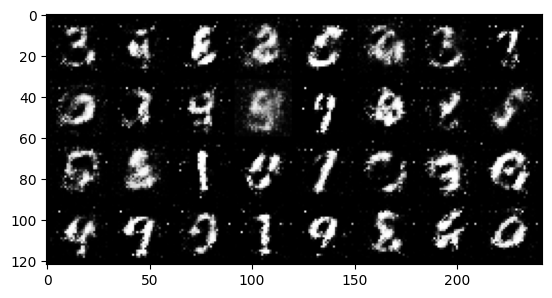

In [26]:
import matplotlib.pyplot as plt 
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())